In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from flowprintOptimal.sekigo.flowUtils.commons import loadFlows, saveFlows
from flowprintOptimal.sekigo.flowUtils.sampler import FixedLengthSampler, FixedLengthSimpleSampler
from flowprintOptimal.sekigo.core.flowRepresentation import FlowRepresentation
from typing import List
from flowprintOptimal.sekigo.flowUtils.flowDatasets import MaxNormalizedDataset,ActivityDataset
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFramePeocessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.flowUtils.commons import getValidInvalidStartingPointsForSubFlowStart
from flowprintOptimal.sekigo.modeling.models import LSTMModel, RandomForestModel
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMClassifier
from flowprintOptimal.sekigo.modeling.loggers import Logger
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from joblib import delayed, Parallel

In [2]:
flows = loadFlows(path= "/Users/rushi/Desktop/UNSW/data/VNAT/flowStore/vnatflows1second.json")

In [3]:
providers = pd.Series(list(map(lambda x : x.class_type, flows)))

In [4]:
providers.value_counts()

nonvpn_ssh            13558
nonvpn_scp_long       10555
nonvpn_scp             2288
nonvpn_rsync           1911
nonvpn_sftp            1666
nonvpn_skype_chat      1244
nonvpn_vimeo           1217
nonvpn_youtube          338
nonvpn_voip             318
vpn_voip                299
nonvpn_netflix          204
vpn_skype_chat           57
nonvpn_rdp               24
nonvpn_rdp_capture        9
vpn_ssh                   5
vpn_rsync                 4
vpn_sftp                  4
vpn_youtube               3
vpn_scp                   2
vpn_rdp                   2
vpn_netflix               1
vpn_vimeo                 1
vpn_rdp_capture           1
Name: count, dtype: int64

In [5]:
class_type_filtered_flows = VNATDataFrameProcessor.convertLabelsToTopLevel(flows)


In [6]:
providers = pd.Series(list(map(lambda x : x.class_type, class_type_filtered_flows)))
providers.value_counts()

FT           16420
control      13591
streaming     1759
chat          1244
Name: count, dtype: int64

In [66]:
sampler = FixedLengthSampler(flow_config= class_type_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .05,min_activity_for_start_point= 30,sample_wise_train_ratio= .8, temporal_train_ratio= 1)

In [67]:
split_flows = sampler.sampleAndCutToLength(data= class_type_filtered_flows)
#split_flows = FixedLengthSimpleSampler.sampleAndCutToLength(data= class_type_filtered_flows,flow_config= class_type_filtered_flows[0].flow_config,required_length_in_seconds= 30,min_activity_for_start_point= 10,train_ratio= .8)

{'FT': 1, 'chat': 0.02737579837374597, 'control': 0.5327235772357723, 'streaming': 0.28794287283713266}
1
1
1
1
2
1
1
1
1
13
25
14
30
27
30
30
30
1
1
1
1
1
30
1
30
30
1
1
30
30
30
9
4
30
30
30
7
30
18
26
30
8
30
30
4
30
25
14
30
30
3
30
30
30
30
4
2
30
30
30
30
1
1
30
1
3
2
30
2
1
2
3
30
30
2
30
2
2
30
2
2
30
30
30
30
1
30
2
3
30
30
30
2
30
1
3
30
3
3
2
1
30
1
30
30
30
1
30
30
1
30
1
30
30
30
30
30
30
30
1
30
3
30
30
30
30
30
3
2
30
1
1
2
2
3
30
30
30
30
1
3
3
1
30
30
30
2
1
30
30
2
2
3
30
1
2
30
2
30
30
30
14
30
30
30
30
30
30
30
3
30
30
3
3
30
1
30
30
30
30
2
30
1
2
2
30
30
28
30
30
30
30
30
30
30
30
30
30
9
30
30
30
30
30
30
30
30
1
30
21
30
30
30
30
30
30
30
15
16
1
30
1
30
3
30
1
1
1
1
30
30
30
30
1
2
30
30
30
30
30
30
30
1
30
1
30
30
3
1
1
3
2
3
2
1
1
3
1
1
30
30
30
30
30
30
30
2
1
30
2
3
2
3
30
30
2
30
30
1
30
2
3
30
30
1
1
3
1
1
1
20
1
1
1
1
1
1
30
2
1
2
1
3
18
30
1
1
1
1
2
1
30
1
1
1
1
30
1
1
1
1
1
30
2
5
1
30
30
30
1
1
1
30
2
30
1
1
1
30
1
5
1
1
1
1
30
1
1
1
30
2
30
1
30
30
1

In [68]:
train_flows = split_flows["train_flows"]
test_flows = split_flows["test_flows"]
activity_dataset_train = ActivityDataset(flows= train_flows,label_to_index= None)
activity_dataset_test = ActivityDataset(flows= test_flows, label_to_index= activity_dataset_train.label_to_index)

In [69]:
pd.Series(map(lambda x : x.class_type,split_flows["train_flows"])).value_counts()

chat         4699
control      4624
streaming    4330
FT            415
Name: count, dtype: int64

In [70]:
pd.Series(map(lambda x : x.class_type,split_flows["test_flows"])).value_counts()

streaming    1107
control       802
chat          595
FT            224
Name: count, dtype: int64

In [71]:
lstm_input_size  = activity_dataset_train[0]["flow"].shape[1]

In [72]:
logger = Logger()
classifier = LSTMClassifier(lstm_hidden_size= 64, lstm_input_size = lstm_input_size,num_classes= len(activity_dataset_train.label_to_index))
trainer = LSTMModel(model= classifier, train_dataset= activity_dataset_train, test_dataset= activity_dataset_test, logger = logger,model_dir_path= "/Users/rushi/Desktop/UNSW/flowprintOptimal/artifacts/classification/lstm",
                    model_name= "LSTM_.5_grain"
                    )

In [73]:
trainer.train(epochs= 120,batch_size= 64,lr = .001)

1 metric train_loss = 1.1435345558271015
1 metric test_f1 = 0.22729502911091895
1 metric train_f1 = 0.3158640522318945
2 metric train_loss = 1.0852132015032312
3 metric train_loss = 0.7637090550982244
4 metric train_loss = 0.424556572415513
5 metric train_loss = 0.2649715845579426
6 metric train_loss = 0.2142688149254616
7 metric train_loss = 0.1780922510427291
8 metric train_loss = 0.15579806980102845
9 metric train_loss = 0.1356919662916361
10 metric train_loss = 0.1458834259171192
11 metric train_loss = 0.11717500968849005
2 metric test_f1 = 0.9331776211069601
12 metric train_loss = 0.1012959397104505
13 metric train_loss = 0.09752213540295623
14 metric train_loss = 0.08055401667016962
15 metric train_loss = 0.08138526347572128
16 metric train_loss = 0.0912144913180778
17 metric train_loss = 0.06294403829586322
18 metric train_loss = 0.056294831107094136
19 metric train_loss = 0.05694541455242255
20 metric train_loss = 0.06245919502474215
21 metric train_loss = 0.05118999874977327
3

KeyboardInterrupt: 

0.9635904521124088


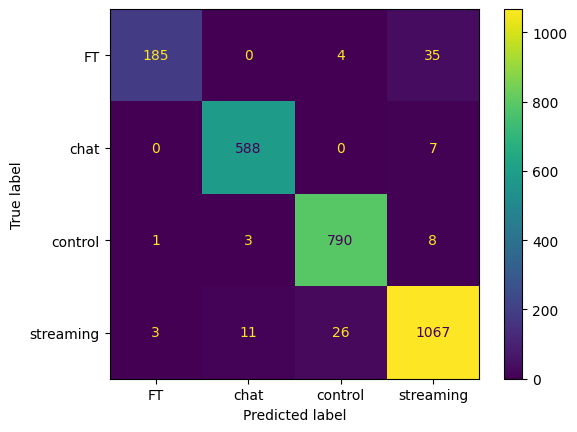

In [74]:
print(trainer.calcTestF1())
trainer.plotConfusionMatrix(dataset= trainer.test_dataset)

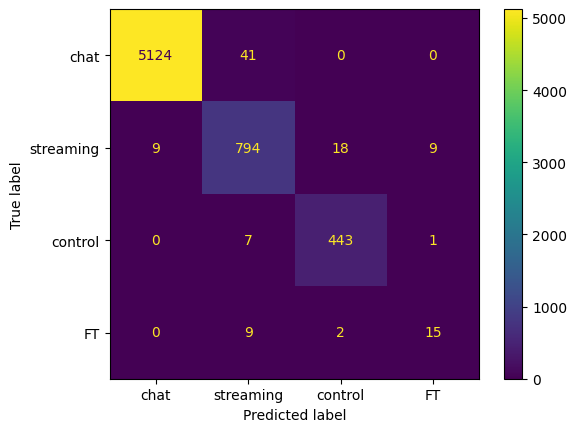

In [65]:
trainer.plotConfusionMatrix(dataset= trainer.train_dataset)

In [40]:
# Analysis time

In [52]:
label_to_images = dict()
for data in activity_dataset_train:
    image, label = data["flow"], data["label"]

    if label not in label_to_images:
        label_to_images[label] = []
    
    label_to_images[label].append(image)

In [57]:
for label in label_to_images:
    label_to_images[label] = np.array(label_to_images[label]).mean(axis= 0)